In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [208]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [209]:
df.shape

(284807, 31)

In [210]:
df.isnull().values.any()

False

## Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

Text(0, 0.5, 'Frequency')

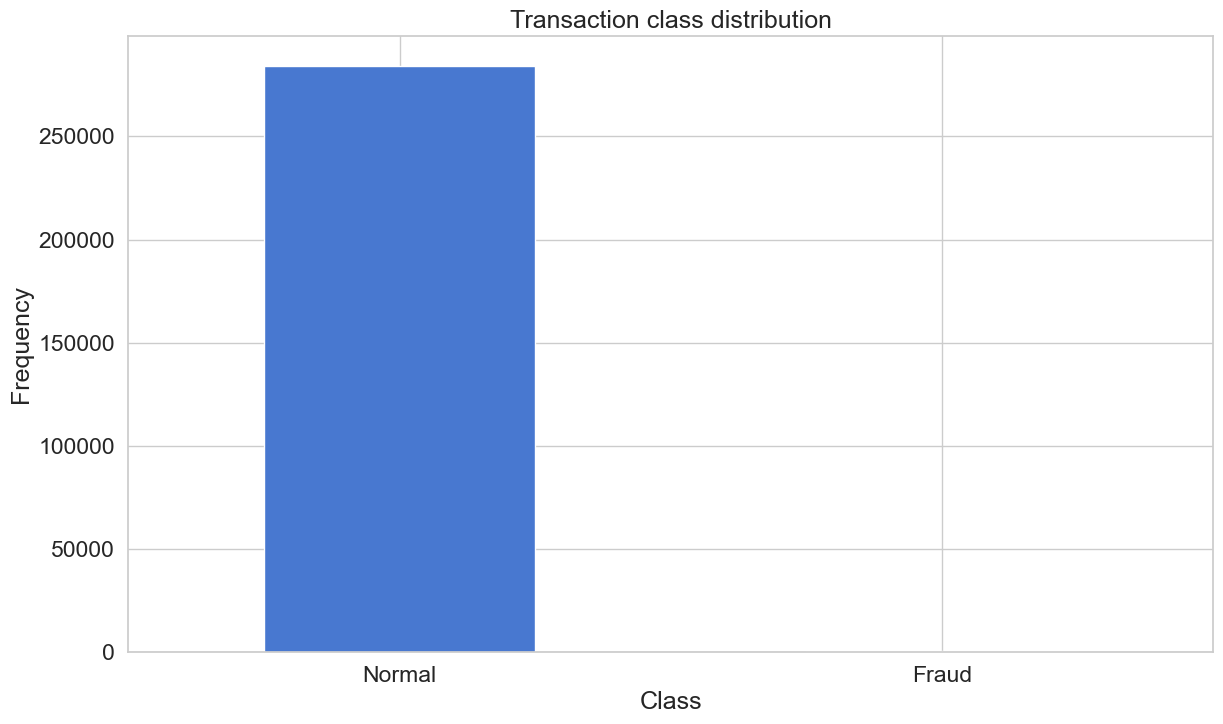

In [211]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [212]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [213]:
normal.shape

(284315, 31)

## Checking the amount of money involved in each kind of transaction

In [214]:
# Fraud transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [215]:
# Non-fraud transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Graphical representation of Amount

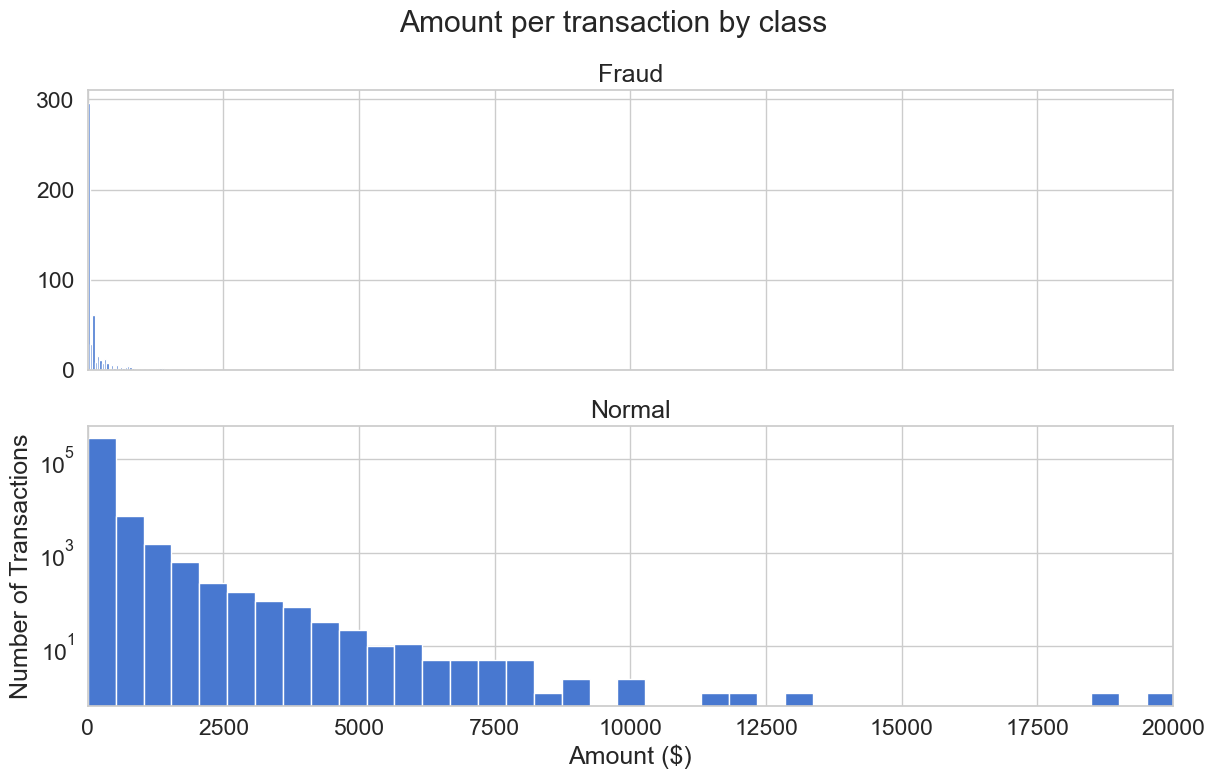

In [216]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

## Plotting time of transaction to check for correlations

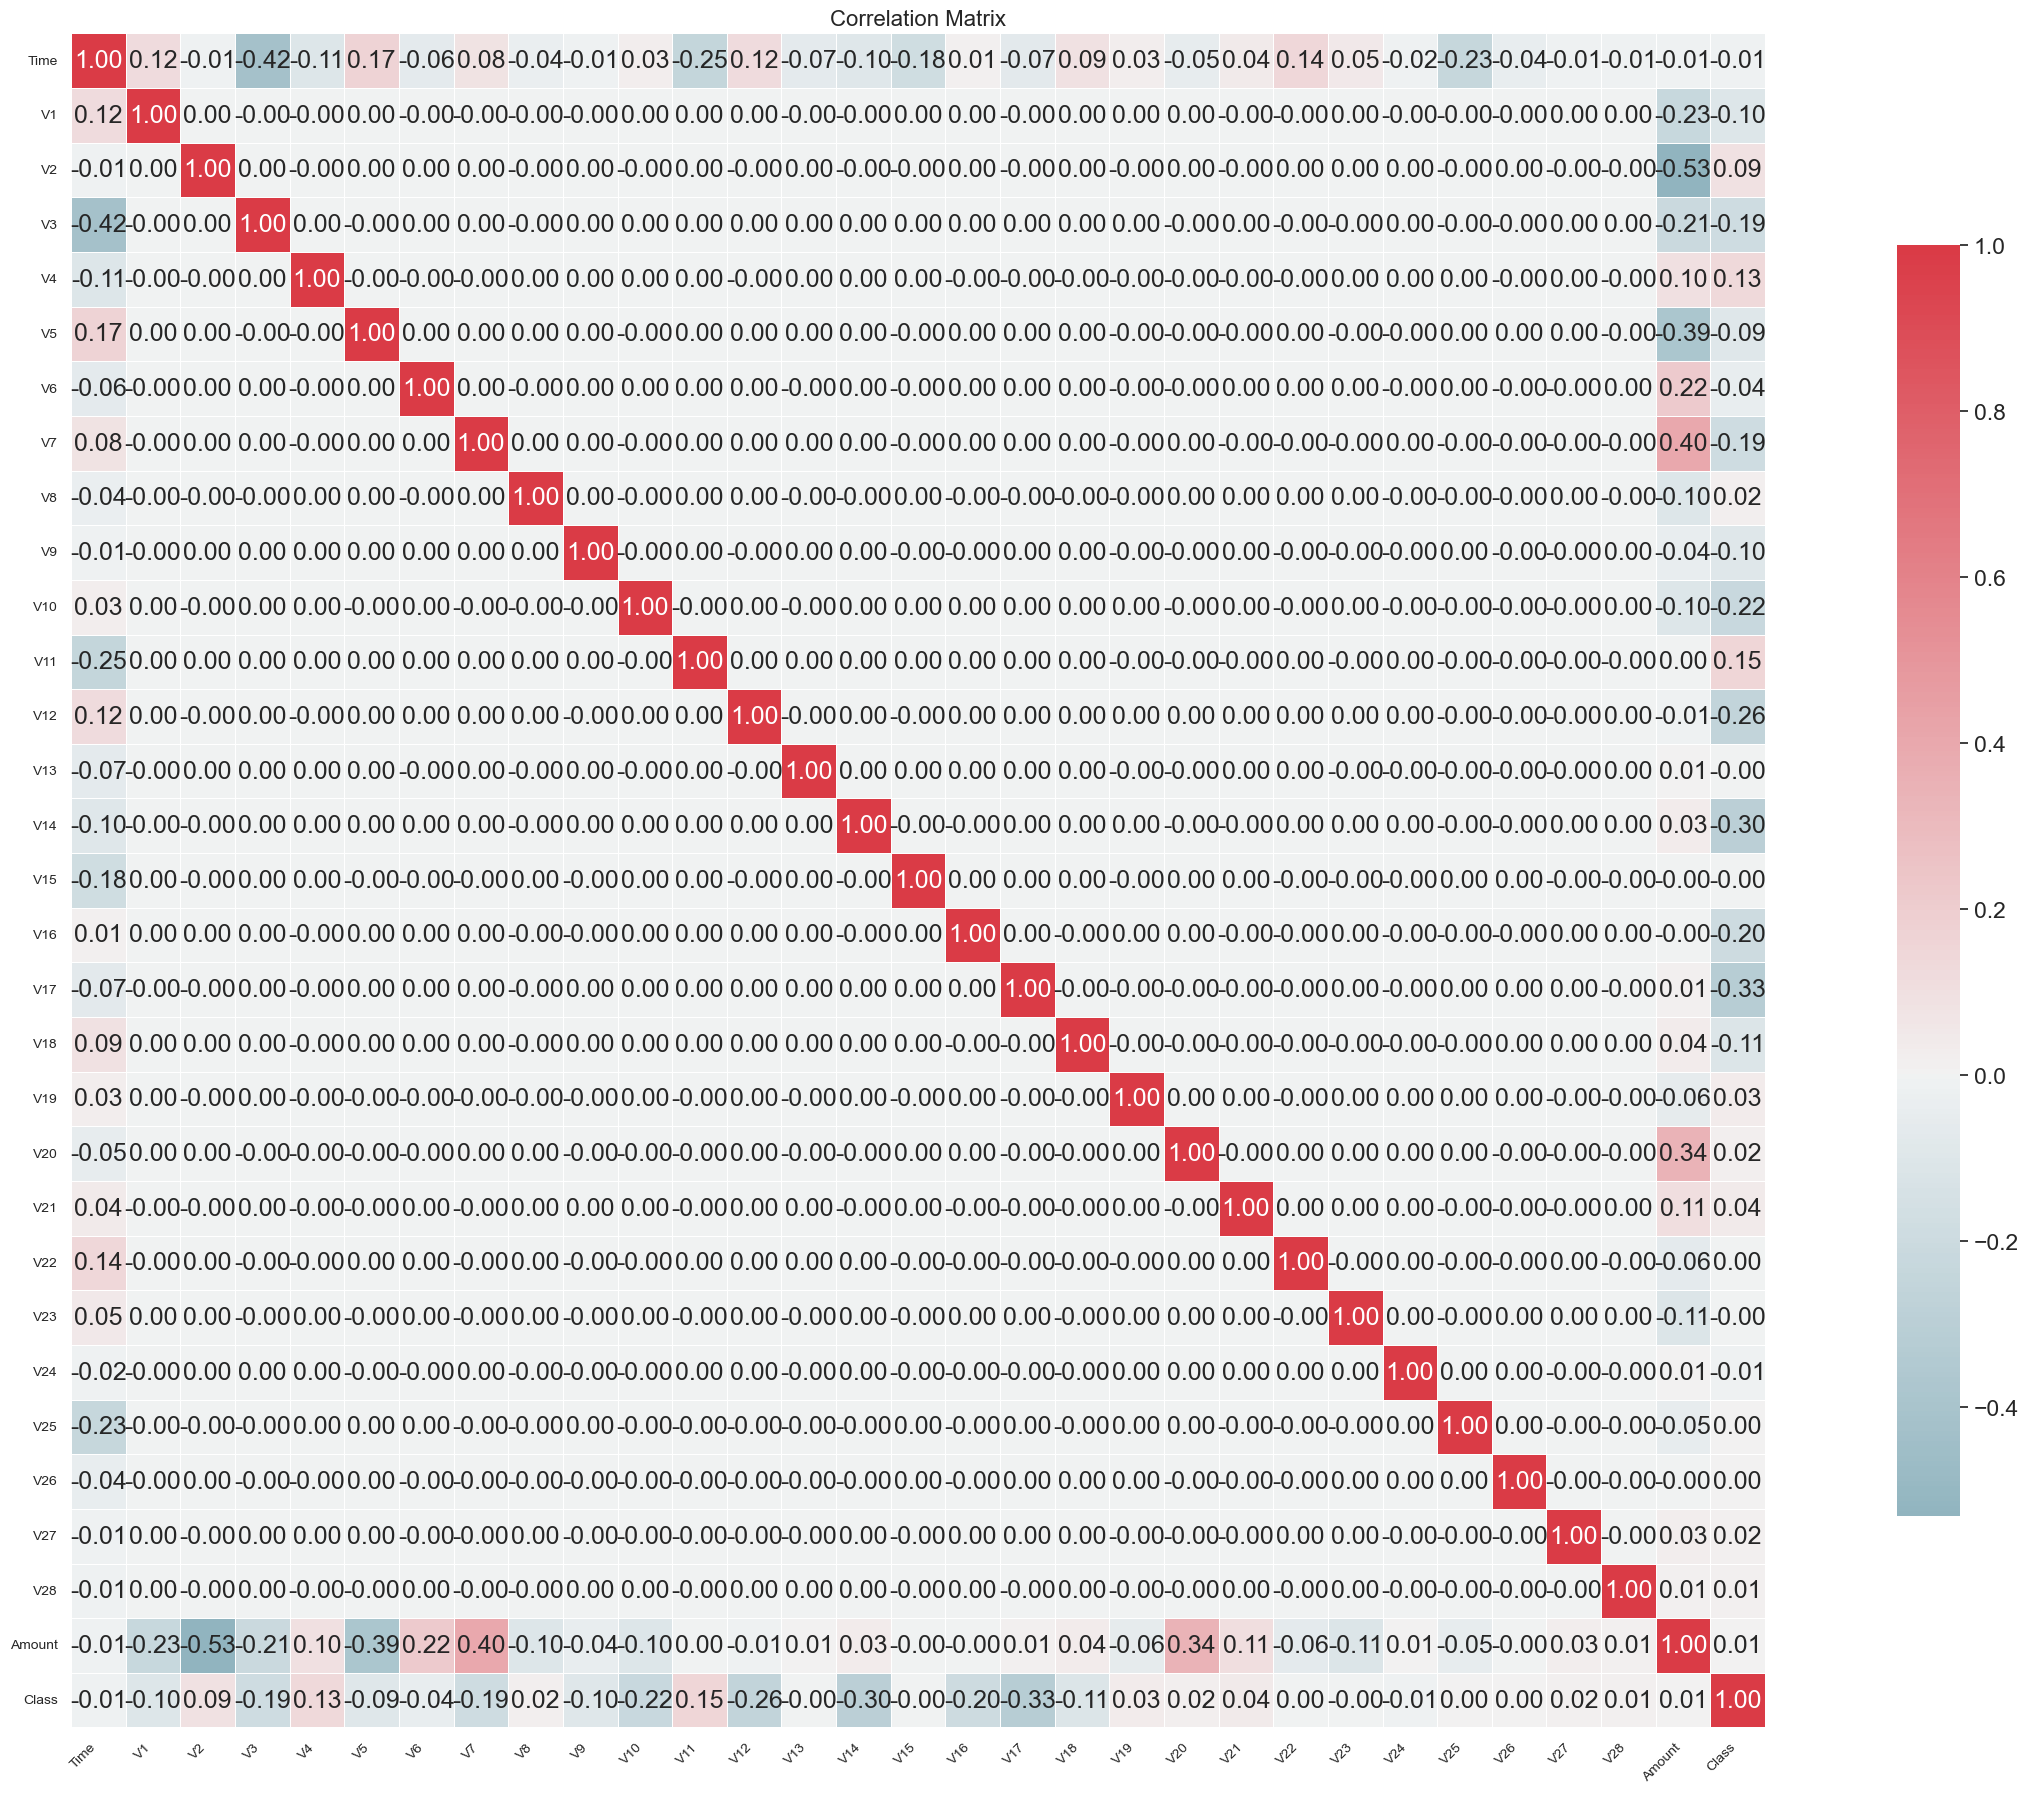

In [217]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(34, 22))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

# Customize the heatmap
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

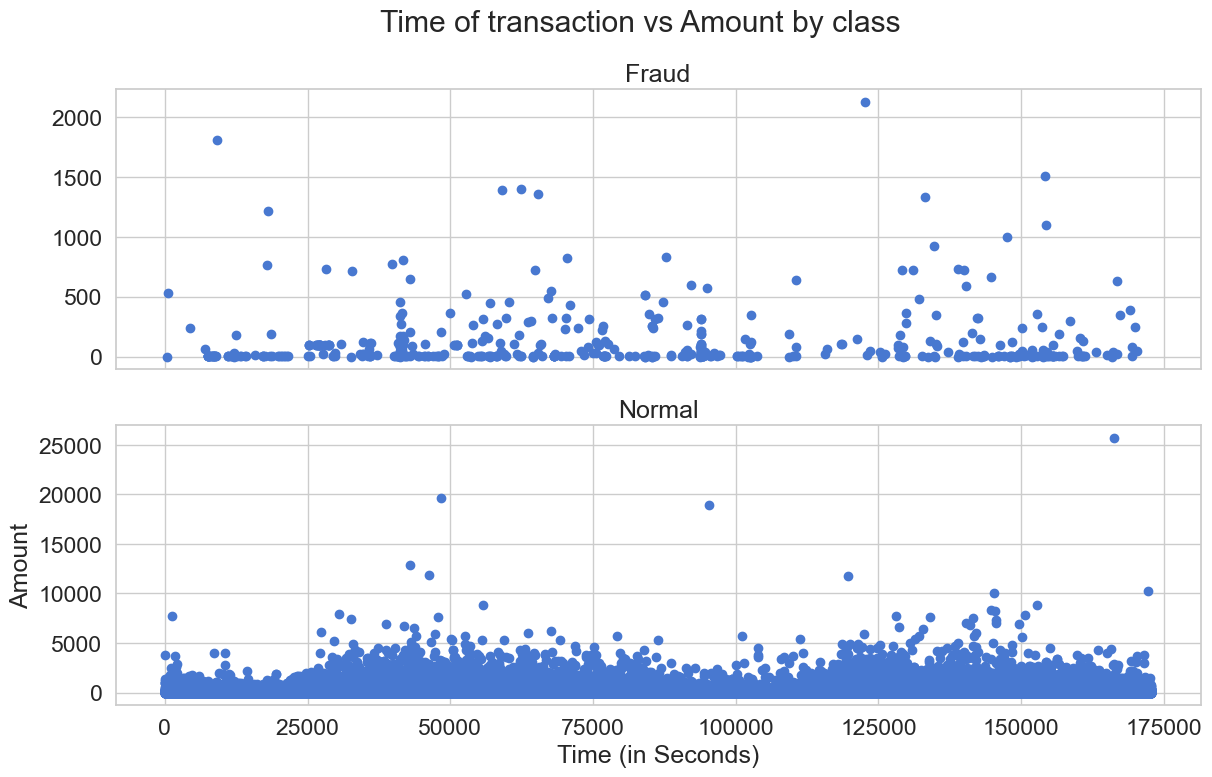

In [218]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [219]:
data = df.drop(['Time'], axis=1)

## Spiting the data into 80% training and 20% testing

In [220]:
X = data.drop(['Class'], axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Autoencoder model

In [221]:

# Build the autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
output_layer = Dense(input_dim, activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training the credit card fraud detection model

In [222]:
# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=256, epochs=10, shuffle=True, validation_split=0.2)


Epoch 1/10
713/713 [==============================] - 3s 1ms/step - loss: 0.1992 - val_loss: 0.1787
Epoch 2/10
713/713 [==============================] - 1s 1ms/step - loss: 0.1486 - val_loss: 0.1176
Epoch 3/10
713/713 [==============================] - 1s 969us/step - loss: 0.0987 - val_loss: 0.0826
Epoch 4/10
713/713 [==============================] - 1s 982us/step - loss: 0.0764 - val_loss: 0.0728
Epoch 5/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0717 - val_loss: 0.0711
Epoch 6/10
713/713 [==============================] - 1s 985us/step - loss: 0.0709 - val_loss: 0.0708
Epoch 7/10
713/713 [==============================] - 1s 978us/step - loss: 0.0707 - val_loss: 0.0708
Epoch 8/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 9/10
713/713 [==============================] - 1s 986us/step - loss: 0.0707 - val_loss: 0.0707
Epoch 10/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0707 - val_lo

Epoch 1/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 2/10
713/713 [==============================] - 1s 980us/step - loss: 0.0707 - val_loss: 0.0707
Epoch 3/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 4/10
713/713 [==============================] - 1s 979us/step - loss: 0.0707 - val_loss: 0.0707
Epoch 5/10
713/713 [==============================] - 1s 977us/step - loss: 0.0707 - val_loss: 0.0707
Epoch 6/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0707
Epoch 7/10
713/713 [==============================] - 1s 1000us/step - loss: 0.0707 - val_loss: 0.0707
Epoch 8/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0707
Epoch 9/10
713/713 [==============================] - 1s 989us/step - loss: 0.0706 - val_loss: 0.0707
Epoch 10/10
1781/1781 [==============================] - 1s 317us/step


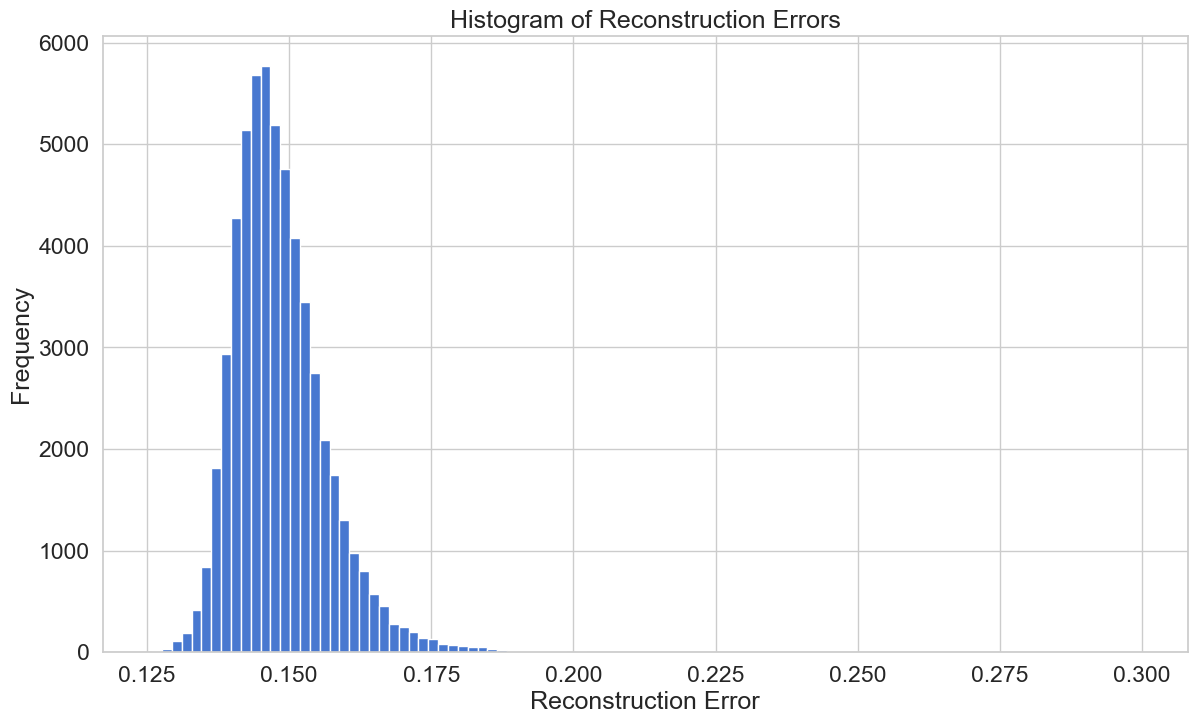

In [223]:
# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=256, epochs=10, shuffle=True, validation_split=0.2)

# Reconstruct input features
reconstructions = autoencoder.predict(X_test_scaled)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.abs(reconstructions - X_test_scaled), axis=1)

# Visualize reconstruction errors
plt.figure()
plt.hist(reconstruction_errors, bins=100)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.show()


# Obtain the Hidden Representation

In [224]:

# Obtain the hidden representation
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])


## Model Prediction

In [225]:
norm_hid_rep = hidden_representation.predict(X_train_scaled[y_train == 0])
fraud_hid_rep = hidden_representation.predict(X_train_scaled[y_train == 1])

13/13 [==============================] - 0s 259us/step


## Credit Card Fraud Detection Prediction model(Auto Encoder)

In [226]:

# Evaluation
print("\nClassification Report:")
print(classification_report(val_y, pred_y))
print("\nAccuracy Score:", accuracy_score(val_y, pred_y))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56859
         1.0       0.88      0.45      0.59       103

    accuracy                           1.00     56962
   macro avg       0.94      0.72      0.80     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score: 0.9988939995084443


# Logistic Regression model

In [227]:

# Create a dataset for the logistic regression model
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=RANDOM_SEED)

# Train logistic regression model
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)

# Predict using the logistic regression model
pred_y = clf.predict(val_x)

## Credit Card Fraud Detection Prediction model(Logistic Regression)

In [228]:

# Generate the classification report
print("\nClassification Report (Logistic Regression):")
print(classification_report(val_y, pred_y))
print("\nAccuracy Score:", accuracy_score(val_y, pred_y))



Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56859
         1.0       0.87      0.40      0.55       103

    accuracy                           1.00     56962
   macro avg       0.94      0.70      0.77     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score: 0.9988062216916541


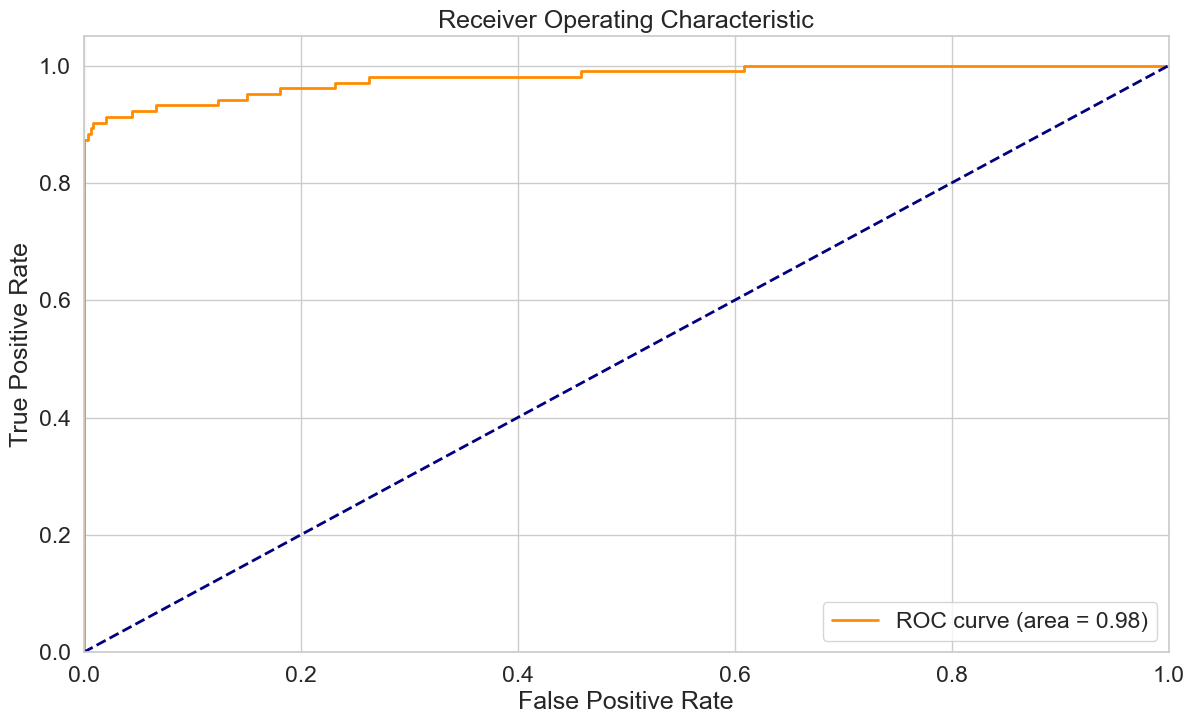

In [229]:
# ROC curve
fpr, tpr, _ = roc_curve(val_y, clf.predict_proba(val_x)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

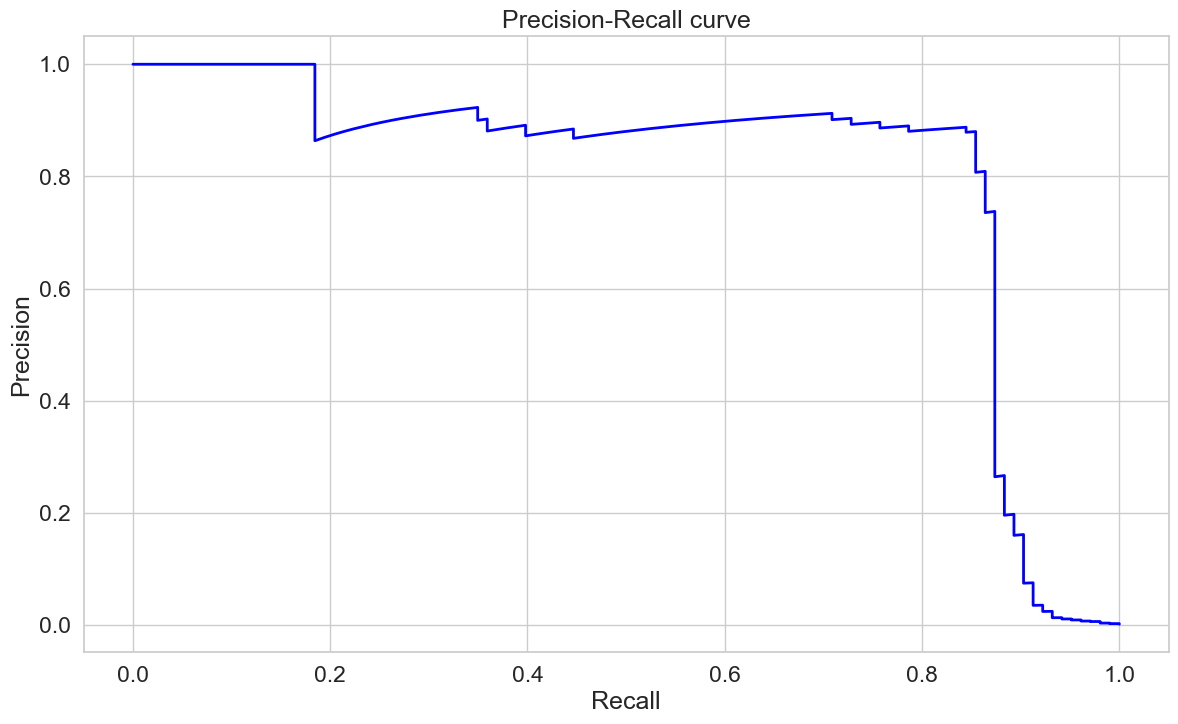

In [230]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(val_y, clf.predict_proba(val_x)[:, 1])
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

1781/1781 [==============================] - 1s 284us/step


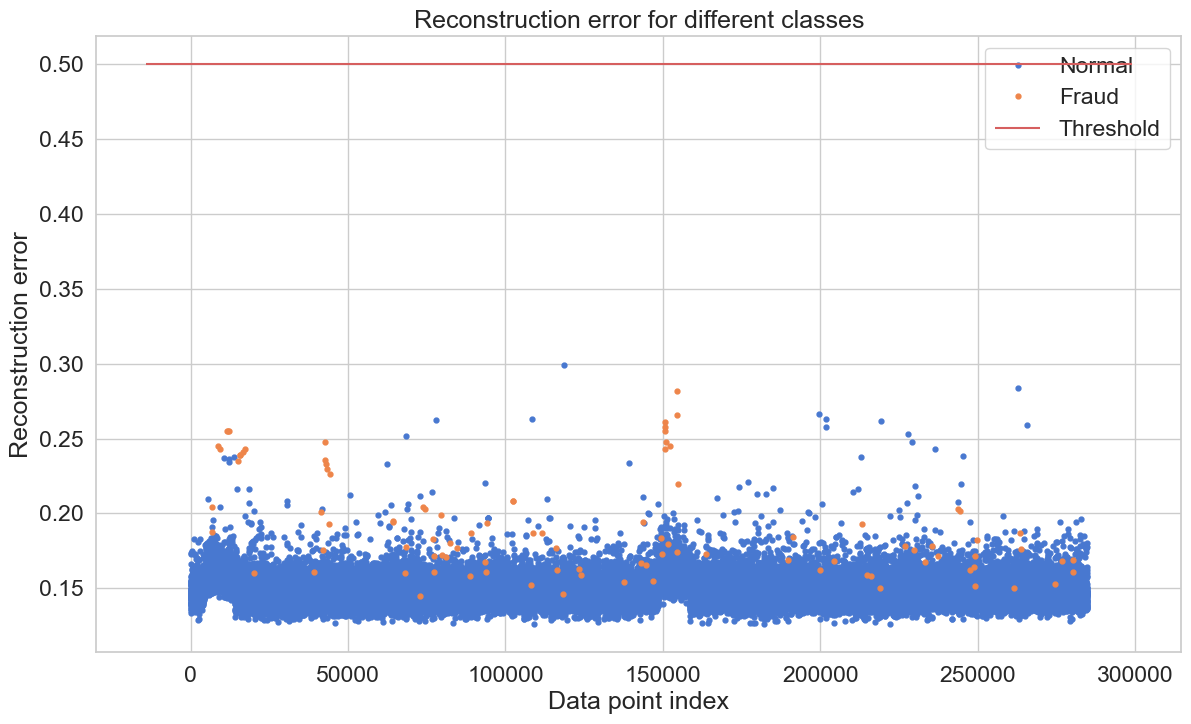

In [231]:
# Heatmap of reconstruction errors
reconstructions = autoencoder.predict(X_test_scaled)
reconstruction_errors = np.mean(np.abs(reconstructions - X_test_scaled), axis=1)
error_df = pd.DataFrame({'reconstruction_error': reconstruction_errors, 'true_class': y_test})
threshold_fixed = 0.5

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


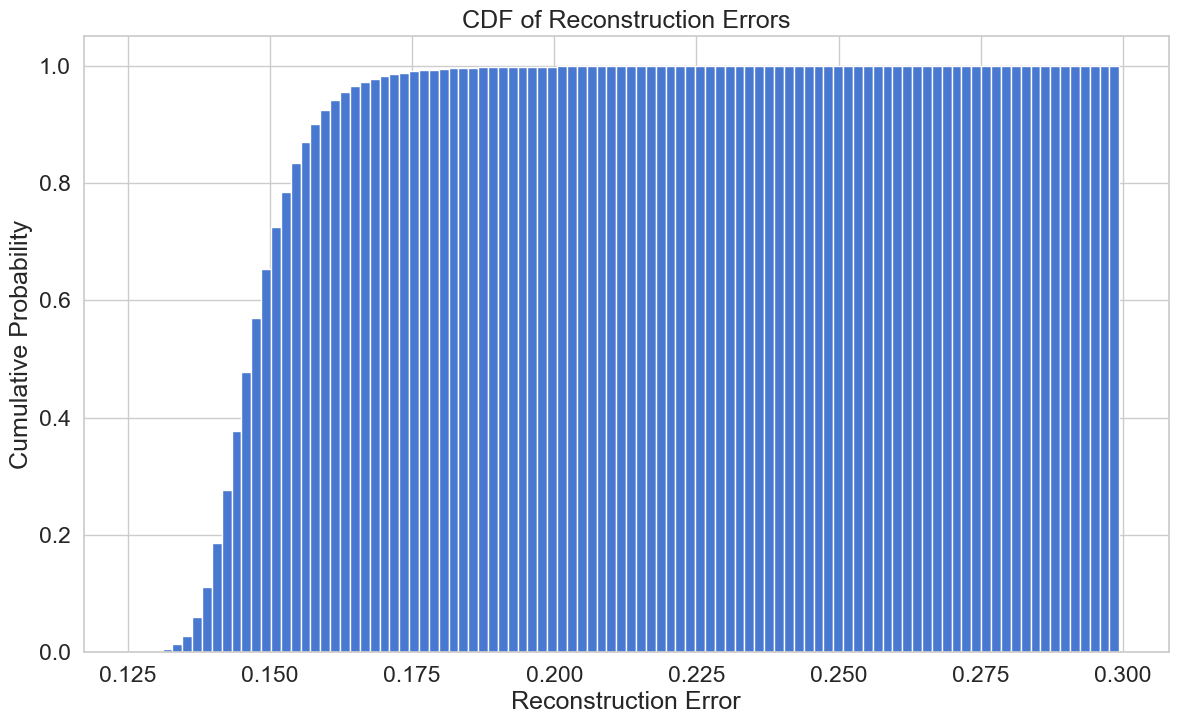

In [232]:
# CDF of Reconstruction Errors
plt.figure()
plt.hist(reconstruction_errors, bins=100, cumulative=True, density=True)
plt.title('CDF of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Cumulative Probability')
plt.show()

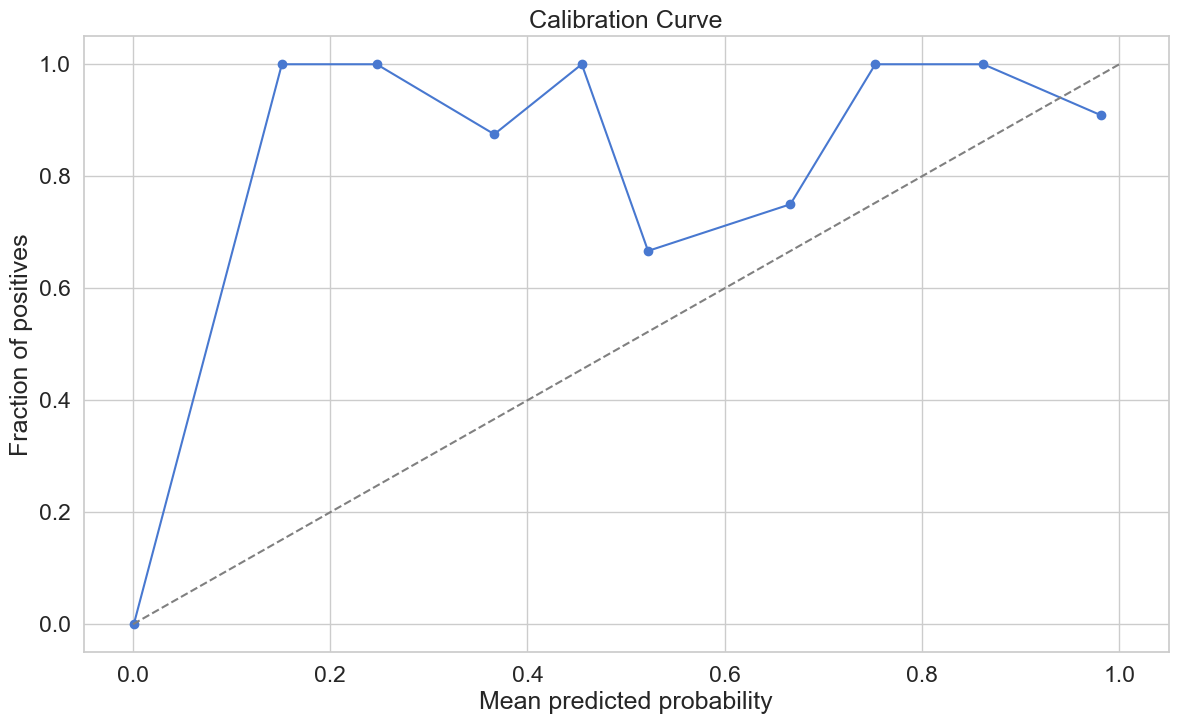

In [233]:
# Calibration Curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(val_y, clf.predict_proba(val_x)[:, 1], n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.show()

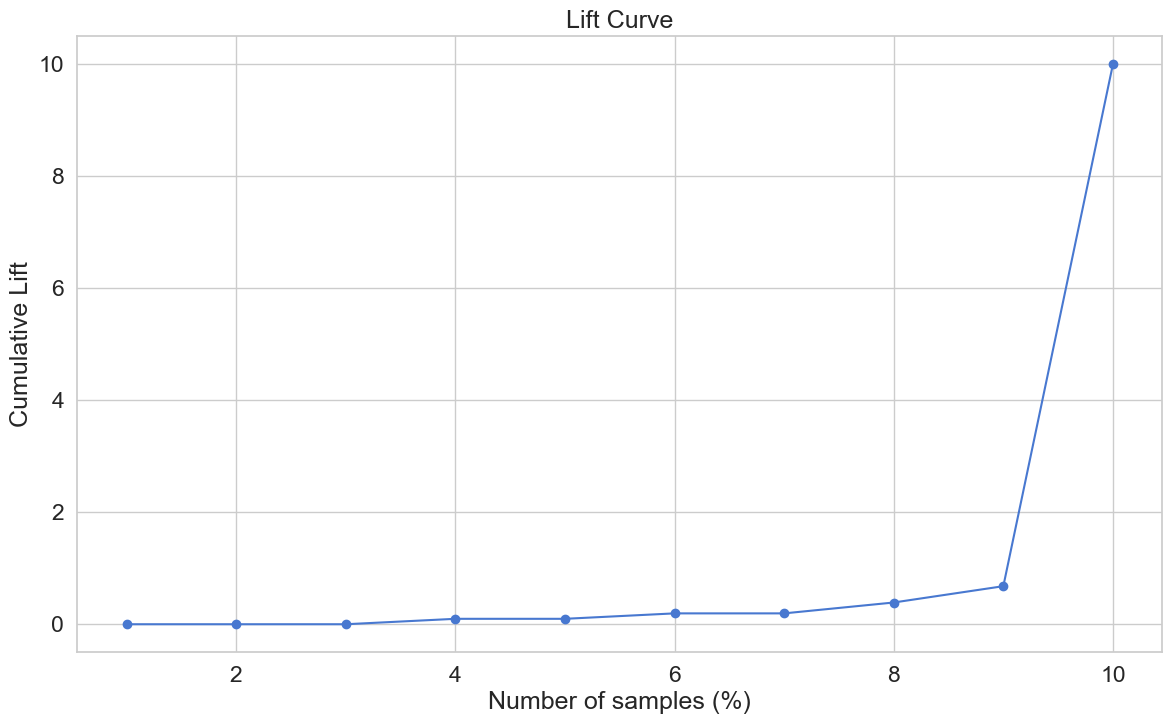

In [234]:
# Lift Curve
from sklearn.metrics import auc
def plot_lift_curve(y_true, y_proba):
    df = pd.DataFrame({'true': y_true, 'prob': y_proba})
    df = df.sort_values(by='prob', ascending=False)
    df['decile'] = pd.qcut(df['prob'], 10, labels=False)
    lift = df.groupby('decile')['true'].mean() / df['true'].mean()
    cum_lift = lift.cumsum()
    plt.plot(cum_lift.index + 1, cum_lift.values, marker='o', linestyle='-')
    plt.xlabel('Number of samples (%)')
    plt.ylabel('Cumulative Lift')
    plt.title('Lift Curve')
    plt.show()

plot_lift_curve(val_y, clf.predict_proba(val_x)[:, 1])


/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Class'] == 0][feature], label='Normal', hist=False)
/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

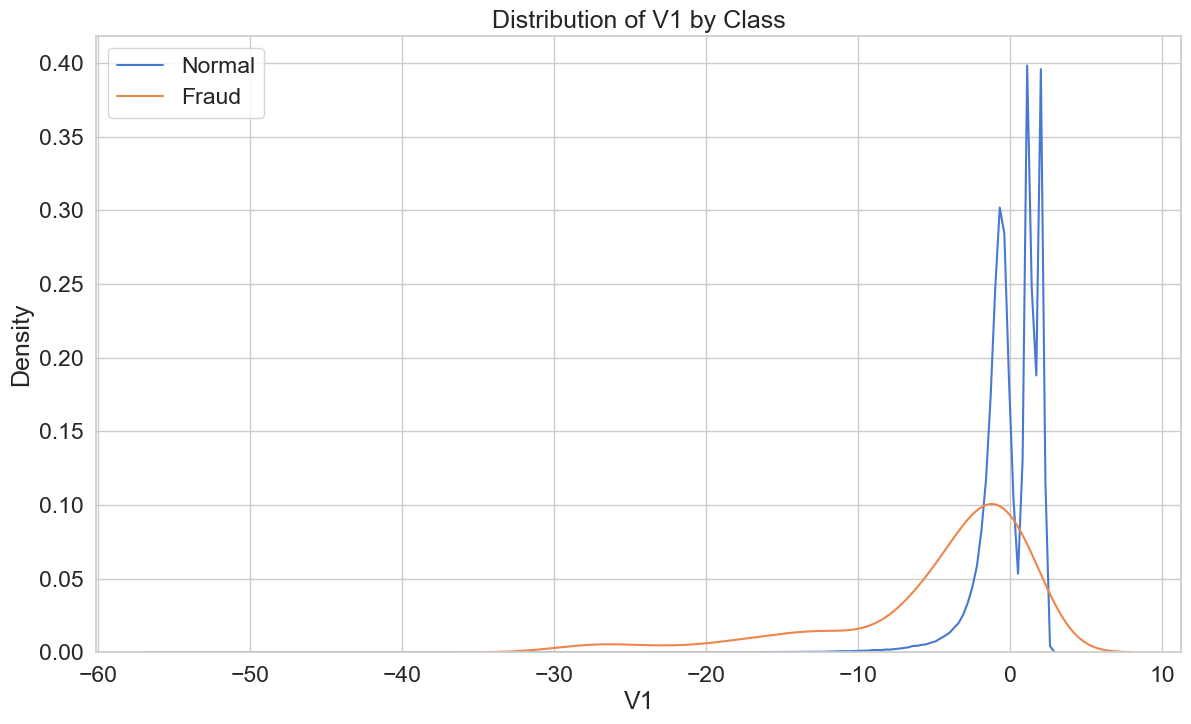

/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Class'] == 0][feature], label='Normal', hist=False)
/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

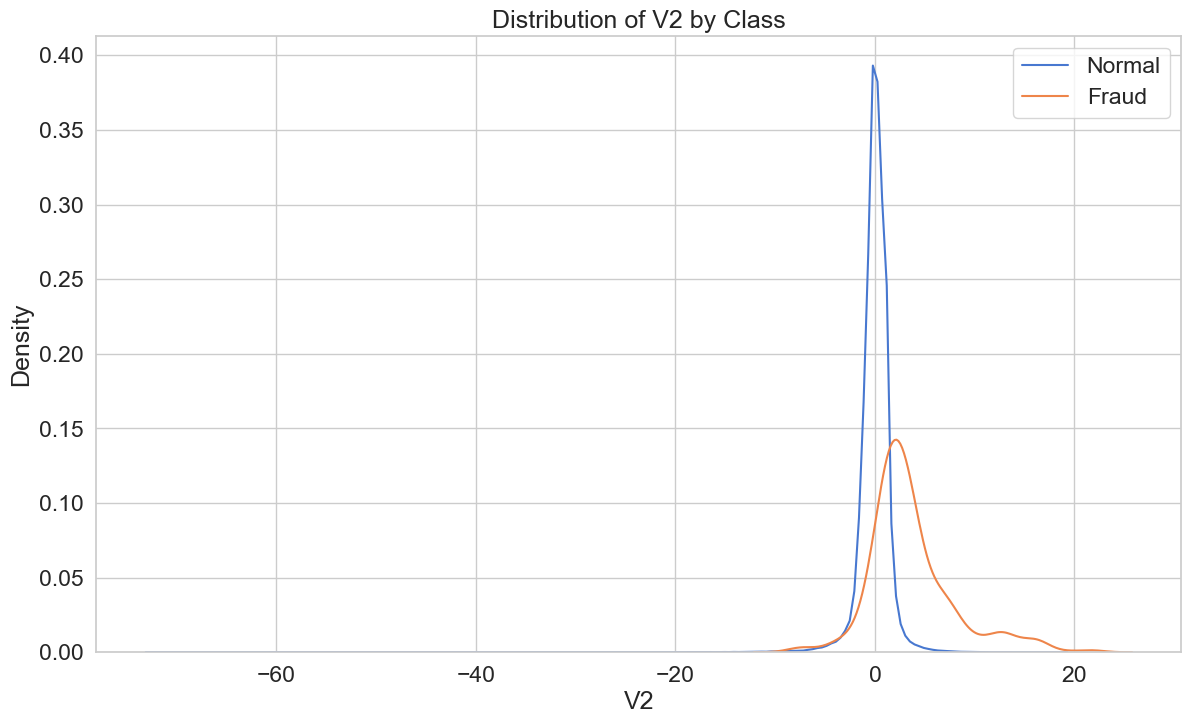

/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Class'] == 0][feature], label='Normal', hist=False)
/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39221/536505414.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

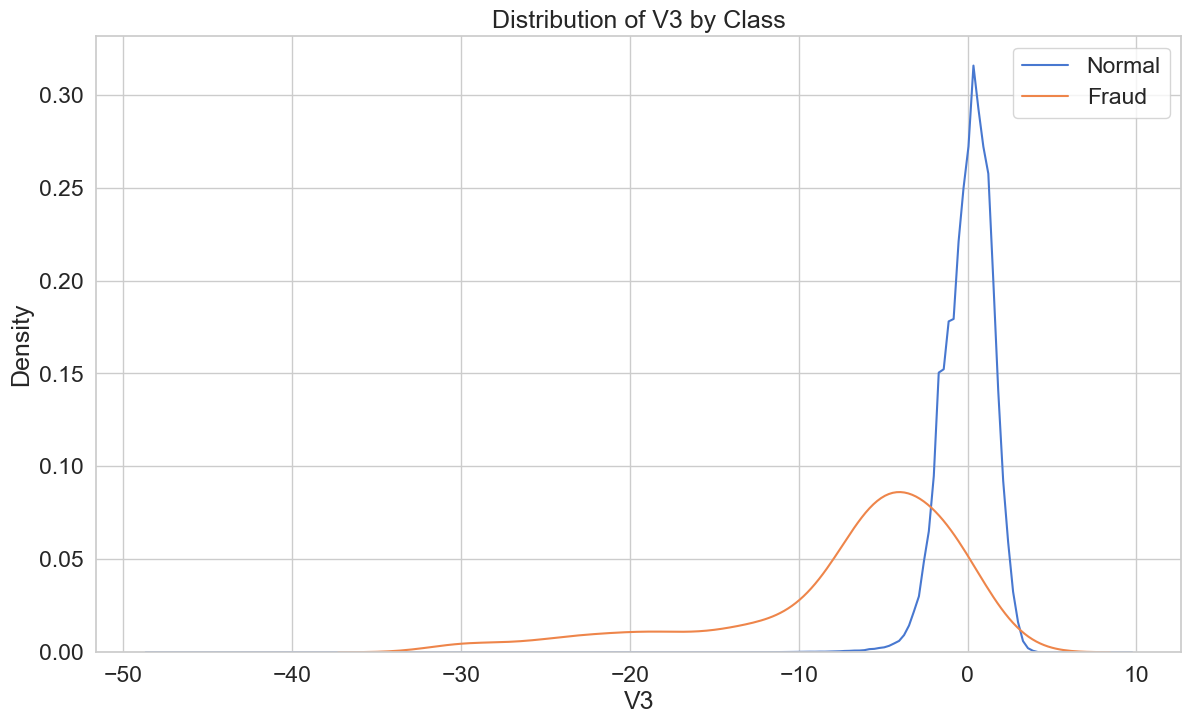

Epoch 1/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0707
Epoch 2/10
713/713 [==============================] - 1s 975us/step - loss: 0.0706 - val_loss: 0.0707
Epoch 3/10
713/713 [==============================] - 1s 974us/step - loss: 0.0706 - val_loss: 0.0707
Epoch 4/10
713/713 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0706
Epoch 5/10
713/713 [==============================] - 1s 984us/step - loss: 0.0706 - val_loss: 0.0706
Epoch 6/10
713/713 [==============================] - 1s 974us/step - loss: 0.0706 - val_loss: 0.0706
Epoch 7/10
713/713 [==============================] - 1s 973us/step - loss: 0.0706 - val_loss: 0.0706
Epoch 8/10
713/713 [==============================] - 1s 973us/step - loss: 0.0706 - val_loss: 0.0706
Epoch 9/10
713/713 [==============================] - 1s 975us/step - loss: 0.0706 - val_loss: 0.0706
Epoch 10/10
13/13 [==============================] - 0s 279us/step
Epoch 1/10
713/713 

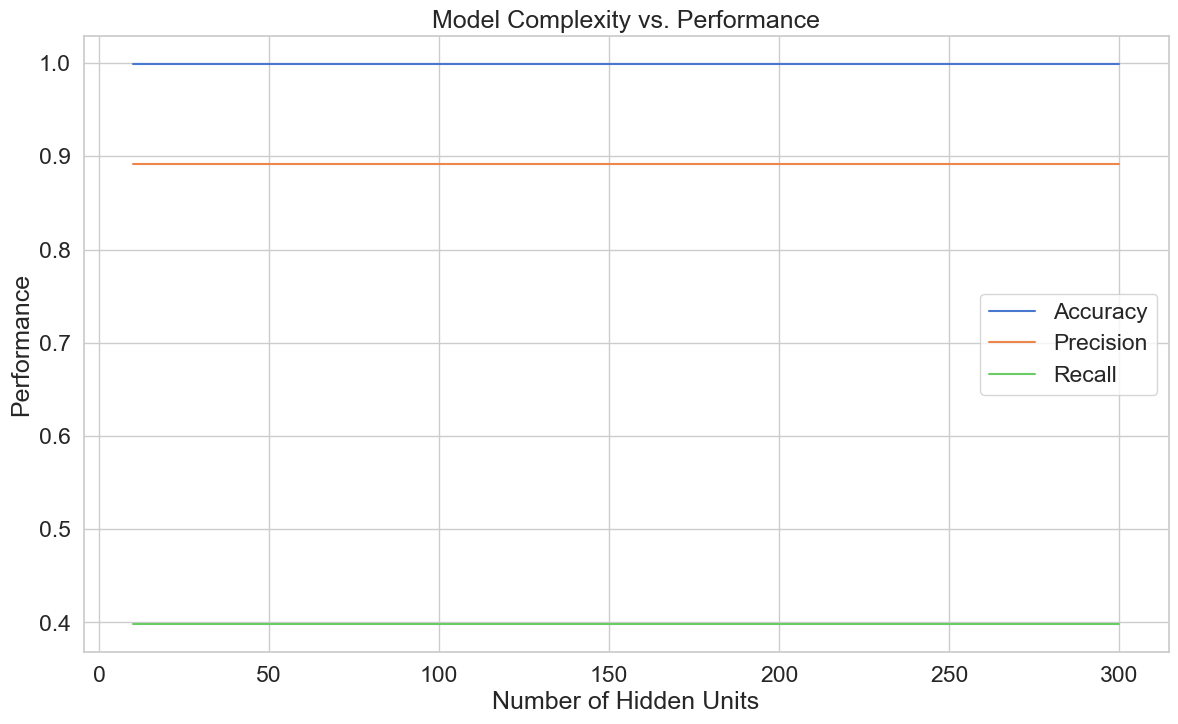

In [235]:
from sklearn.metrics import precision_score, recall_score

# Model Complexity vs. Performance
hidden_units = [10, 50, 100, 200, 300]  # Example hidden units for autoencoder
accuracies = []
precisions = []
recalls = []

# Feature Distribution Comparisons
def plot_feature_distributions(df, features):
    for feature in features:
        plt.figure()
        sns.distplot(df[df['Class'] == 0][feature], label='Normal', hist=False)
        sns.distplot(df[df['Class'] == 1][feature], label='Fraud', hist=False)
        plt.title(f'Distribution of {feature} by Class')
        plt.legend()
        plt.show()

plot_feature_distributions(df, features=['V1', 'V2', 'V3'])  # Example features

# Model Complexity vs. Performance
hidden_units = [10, 50, 100, 200, 300]  # Example hidden units for autoencoder
accuracies = []
precisions = []
recalls = []

for units in hidden_units:
    # Train autoencoder with different number of hidden units
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=256, epochs=10, shuffle=True, validation_split=0.2)
    
    # Obtain hidden representation
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])
    norm_hid_rep = hidden_representation.predict(X_train_scaled[y_train == 0])
    fraud_hid_rep = hidden_representation.predict(X_train_scaled[y_train == 1])
    
    # Create dataset for logistic regression
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=RANDOM_SEED)
    
    # Train logistic regression model
    clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
    pred_y = clf.predict(val_x)
    
    # Calculate performance metrics
    accuracies.append(accuracy_score(val_y, pred_y))
    precisions.append(precision_score(val_y, pred_y))
    recalls.append(recall_score(val_y, pred_y))

# Plotting
plt.figure()
plt.plot(hidden_units, accuracies, label='Accuracy')
plt.plot(hidden_units, precisions, label='Precision')
plt.plot(hidden_units, recalls, label='Recall')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Performance')
plt.title('Model Complexity vs. Performance')
plt.legend()
plt.show()